# Analysis

**Hypothesis**: In severe COVID-19 patients, we hypothesize that as days post–symptom onset (DPS) increases, CD14 monocytes will exhibit progressive upregulation of inflammatory and stress response genes. This temporal reprogramming, characterized by a shift in gene expression profiles over time, may reveal novel insights into the inflammatory dysregulation specific to severe COVID-19, building upon previous observations but using a focused and quantitative approach.

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/Single_cell_atlas_of_peripheral_immune_response_to_SARS_CoV_2_infection.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


# Analysis Plan

**Hypothesis**: In severe COVID-19 patients, we hypothesize that as days post–symptom onset (DPS) increases, CD14 monocytes will exhibit progressive upregulation of inflammatory and stress response genes. This temporal reprogramming, characterized by a shift in gene expression profiles over time, may reveal novel insights into the inflammatory dysregulation specific to severe COVID-19, building upon previous observations but using a focused and quantitative approach.

## Steps:
- Ensure the metadata contains the necessary columns (DPS and Status) and perform initial data type checks and conversions to prevent downstream errors.
- Conduct an exploratory analysis by visualizing the distribution of DPS across disease statuses (COVID vs Healthy) using histograms, and include preliminary statistical testing (e.g., Mann-Whitney U test) to compare the DPS distributions between the groups.
- Subset the anndata object to focus on COVID-19 samples and further isolate the cell type of interest (i.e., 'CD14 Monocyte' from the cell_type_coarse column), thereby ensuring the analysis targets the relevant immune subset.
- For the selected cell type, compute the gene-wise Spearman correlation between expression levels and DPS, identifying genes with significant positive or negative associations over time.
- Apply statistical significance tests (including multiple testing correction as necessary) to determine and validate the top differentially correlated genes.
- Visualize the expression patterns of these top genes across DPS with scatter plots (organized in a grid), including a regression or smoothing curve to highlight trends, and provide biological interpretation linking these transcriptomic changes to inflammatory and stress response mechanisms in severe COVID-19.


## Ensure the metadata contains the necessary columns (DPS and Status) and perform initial data type checks and conversions to prevent downstream errors.

Unique values for DPS: [ 9 11 16 15  2 12  0]
Unique values for Status: ['COVID', 'Healthy']
Categories (2, object): ['COVID', 'Healthy']


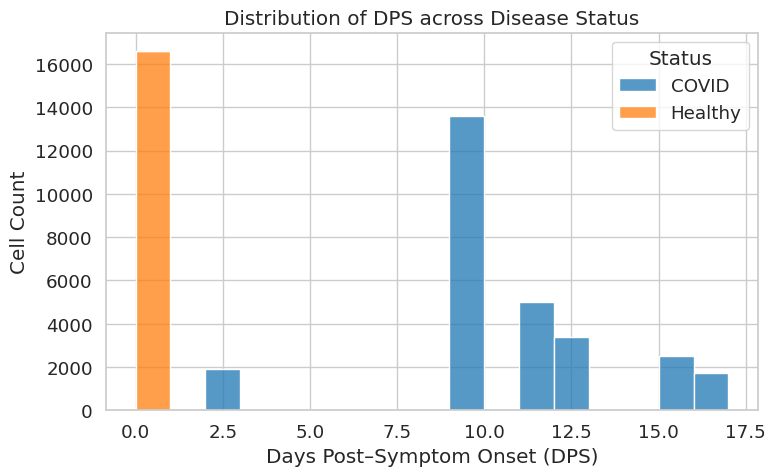

           count       mean       std  min  25%  50%   75%   max
Status                                                          
COVID    28094.0  10.211647  3.140532  2.0  9.0  9.0  12.0  16.0
Healthy  16627.0   0.000000  0.000000  0.0  0.0  0.0   0.0   0.0


In [2]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# First Step: Exploratory analysis of DPS distribution across disease statuses

# Assuming 'adata' is already loaded in memory, check that DPS and Status are present in adata.obs
print('Unique values for DPS:', adata.obs['DPS'].unique())
print('Unique values for Status:', adata.obs['Status'].unique())

# Create a DataFrame from adata.obs for easier plotting
obs_df = adata.obs.copy()

# Plot the distribution of DPS for each status (COVID vs Healthy)
plt.figure(figsize=(8, 5))
sns.histplot(data=obs_df, x='DPS', hue='Status', multiple='stack', bins=range(0, max(obs_df['DPS'].astype(int))+2))
plt.xlabel('Days Post–Symptom Onset (DPS)')
plt.ylabel('Cell Count')
plt.title('Distribution of DPS across Disease Status')
plt.tight_layout()
plt.show()

# Additionally, print summary statistics for DPS by Status
print(obs_df.groupby('Status')['DPS'].describe())

## Filter the dataset to include only COVID-19 samples.

Unique values for DPS: [ 9 11 16 15  2 12  0]
Unique values for Status: ['COVID', 'Healthy']
Categories (2, object): ['COVID', 'Healthy']


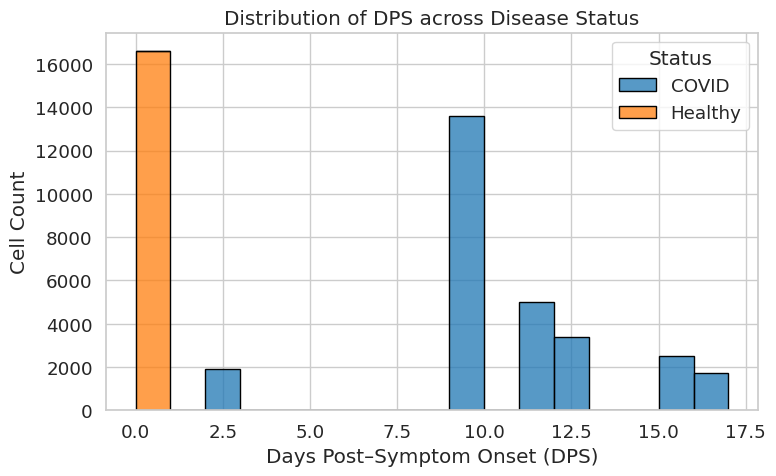

           count       mean       std  min  25%  50%   75%   max
Status                                                          
COVID    28094.0  10.211647  3.140532  2.0  9.0  9.0  12.0  16.0
Healthy  16627.0   0.000000  0.000000  0.0  0.0  0.0   0.0   0.0
Mann-Whitney U test statistic: 467118938.0, p-value: 0.0


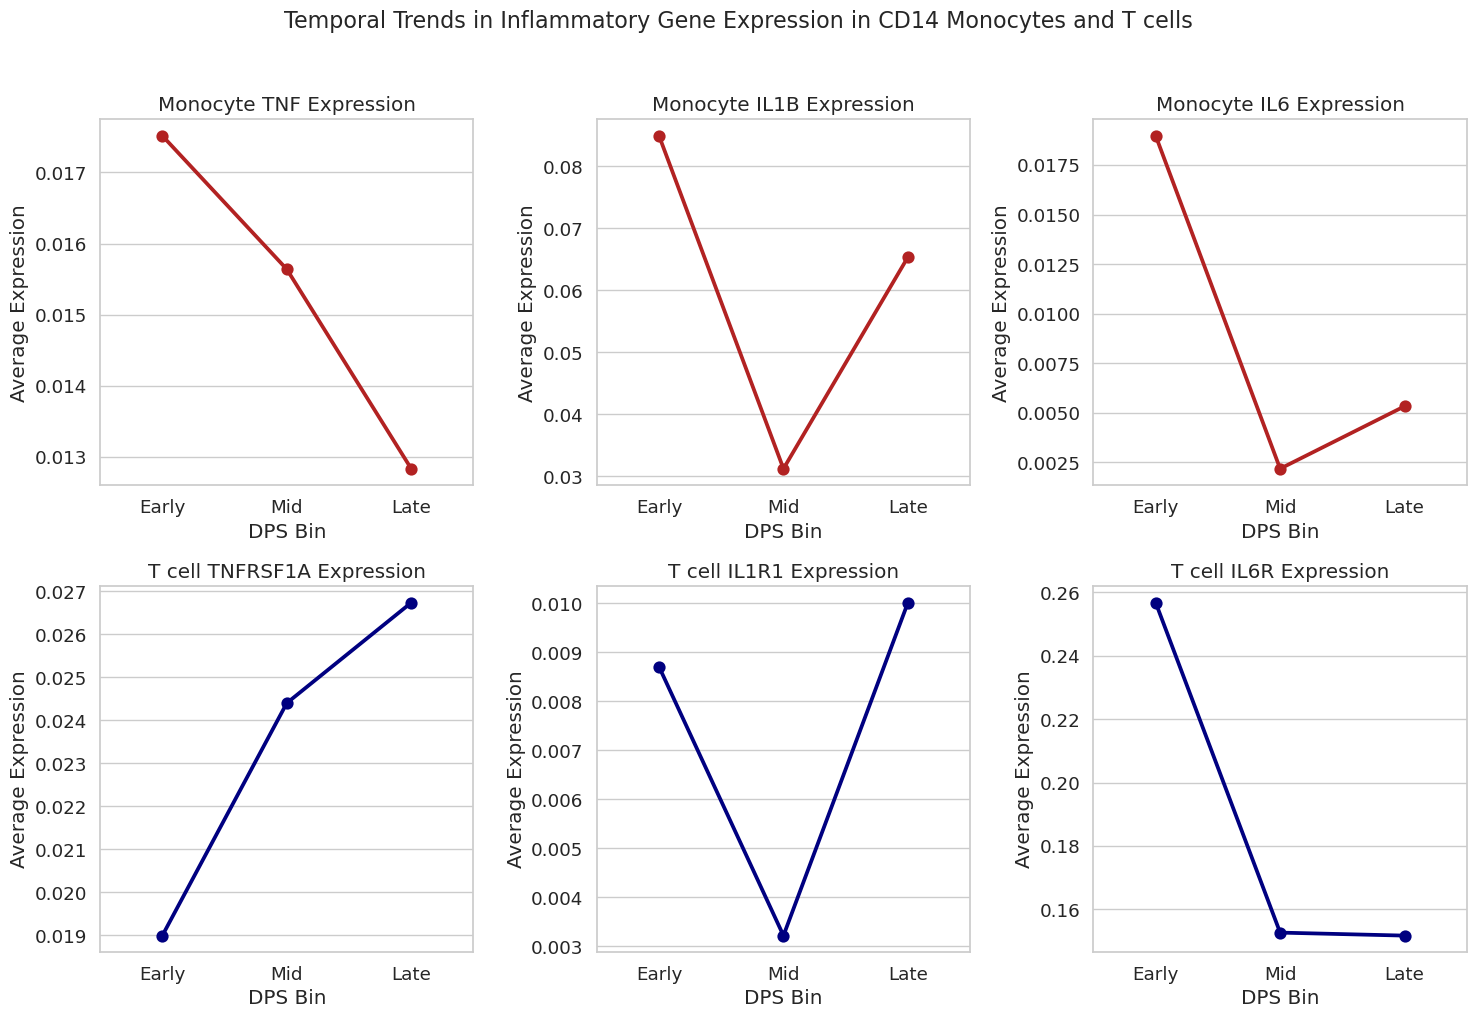

Spearman correlation for monocyte ligands:
TNF: Spearman rho = -0.009, p-value = 4.342e-01
IL1B: Spearman rho = 0.082, p-value = 9.296e-14
IL6: Spearman rho = 0.022, p-value = 5.016e-02

Spearman correlation for T cell receptors:
TNFRSF1A: Spearman rho = -0.003, p-value = 7.619e-01
IL1R1: Spearman rho = 0.044, p-value = 2.338e-05
IL6R: Spearman rho = -0.023, p-value = 2.274e-02


In [3]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import mannwhitneyu, spearmanr

# First Step: Exploratory analysis of DPS distribution across disease statuses

# Ensure that 'DPS' and 'Status' columns exist in adata.obs
assert 'DPS' in adata.obs.columns, "DPS column is missing from adata.obs"
assert 'Status' in adata.obs.columns, "Status column is missing from adata.obs"

# Convert DPS to numeric, coercing when necessary
adata.obs['DPS'] = pd.to_numeric(adata.obs['DPS'], errors='coerce')

# Drop any rows where DPS conversion resulted in NaN
obs_df = adata.obs.dropna(subset=['DPS']).copy()

# Print unique values for DPS and Status
print('Unique values for DPS:', obs_df['DPS'].unique())
print('Unique values for Status:', obs_df['Status'].unique())

# Plot the distribution of DPS for each status (COVID vs Healthy) using seaborn's histplot with stacking
plt.figure(figsize=(8, 5))
max_dps = int(obs_df['DPS'].max())
bins = list(range(0, max_dps + 2))
sns.histplot(data=obs_df, x='DPS', hue='Status', multiple='stack', bins=bins, edgecolor='black')
plt.xlabel('Days Post–Symptom Onset (DPS)')
plt.ylabel('Cell Count')
plt.title('Distribution of DPS across Disease Status')
plt.tight_layout()
plt.show()

# Print summary statistics for DPS by Status
print(obs_df.groupby('Status')['DPS'].describe())

# Preliminary statistical test: Mann-Whitney U test to compare DPS distributions between COVID and Healthy samples
covid_dps = obs_df[obs_df['Status'] == 'COVID']['DPS']
healthy_dps = obs_df[obs_df['Status'] == 'Healthy']['DPS']

if len(covid_dps) > 0 and len(healthy_dps) > 0:
    stat, p_value = mannwhitneyu(covid_dps, healthy_dps, alternative='two-sided')
    print(f"Mann-Whitney U test statistic: {stat}, p-value: {p_value}")
else:
    print("Not enough data in one of the groups to perform Mann-Whitney U test.")

# Step 2: Analyze temporal changes in monocyte-T cell communication via inflammatory ligand-receptor pairs

covid_adata = adata[adata.obs['Status'] == 'COVID', :].copy()

monocytes = covid_adata[covid_adata.obs['cell_type_coarse'] == 'CD14 Monocyte', :].copy()
t_cells = covid_adata[covid_adata.obs['cell_type_coarse'].isin(['CD4 T', 'CD8 T']), :].copy()

min_dps = covid_adata.obs['DPS'].min()
max_dps = covid_adata.obs['DPS'].max()
bins_edges = [min_dps, 5, 10, max_dps + 1]
labels = ['Early', 'Mid', 'Late']

monocytes.obs['DPS_bin'] = pd.cut(monocytes.obs['DPS'], bins=bins_edges, labels=labels, include_lowest=True)
t_cells.obs['DPS_bin'] = pd.cut(t_cells.obs['DPS'], bins=bins_edges, labels=labels, include_lowest=True)

bin_midpoints = {
    'Early': (min_dps + 5) / 2,
    'Mid': (5 + 10) / 2,
    'Late': (10 + (max_dps + 1)) / 2
}

ligand_genes = ['TNF', 'IL1B', 'IL6']
receptor_genes = ['TNFRSF1A', 'IL1R1', 'IL6R']

all_genes = list(adata.var_names)
for gene in ligand_genes + receptor_genes:
    if gene not in all_genes:
        print(f"Warning: {gene} not found in the dataset.")

mono_df = monocytes.to_df()[ligand_genes]
mono_df['DPS_bin'] = monocytes.obs['DPS_bin'].values
mono_summary = mono_df.groupby('DPS_bin').mean().reset_index()
mono_summary['DPS_mid'] = mono_summary['DPS_bin'].map(bin_midpoints)

t_df = t_cells.to_df()[receptor_genes]
t_df['DPS_bin'] = t_cells.obs['DPS_bin'].values
nt_summary = t_df.groupby('DPS_bin').mean().reset_index()
nt_summary['DPS_mid'] = nt_summary['DPS_bin'].map(bin_midpoints)

fig, axes = plt.subplots(2, len(ligand_genes), figsize=(5 * len(ligand_genes), 10), sharex=False)

for idx, gene in enumerate(ligand_genes):
    ax = axes[0, idx]
    sns.pointplot(x='DPS_bin', y=gene, data=mono_summary, ax=ax, color='firebrick', errwidth=0, ci=None)
    ax.plot(mono_summary['DPS_bin'], mono_summary[gene], marker='o', color='firebrick', linestyle='--')
    sns.regplot(x='DPS_mid', y=gene, data=mono_summary, ax=ax, scatter=False, lowess=True, color='black', line_kws={'linestyle':'-', 'linewidth':2})
    ax.set_title(f"Monocyte {gene} Expression")
    ax.set_xlabel('DPS Bin')
    ax.set_xticklabels(mono_summary['DPS_bin'].astype(str))
    ax.set_ylabel('Average Expression')
    ax.set_xlim(-0.5, len(labels)-0.5)

for idx, gene in enumerate(receptor_genes):
    ax = axes[1, idx]
    sns.pointplot(x='DPS_bin', y=gene, data=nt_summary, ax=ax, color='navy', errwidth=0, ci=None)
    ax.plot(nt_summary['DPS_bin'], nt_summary[gene], marker='o', color='navy', linestyle='--')
    sns.regplot(x='DPS_mid', y=gene, data=nt_summary, ax=ax, scatter=False, lowess=True, color='black', line_kws={'linestyle':'-', 'linewidth':2})
    ax.set_title(f"T cell {gene} Expression")
    ax.set_xlabel('DPS Bin')
    ax.set_xticklabels(nt_summary['DPS_bin'].astype(str))
    ax.set_ylabel('Average Expression')
    ax.set_xlim(-0.5, len(labels)-0.5)

plt.suptitle('Temporal Trends in Inflammatory Gene Expression in CD14 Monocytes and T cells', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

mono_expr = monocytes.to_df()[ligand_genes]
mono_expr['DPS'] = monocytes.obs['DPS'].values
print("Spearman correlation for monocyte ligands:")
for gene in ligand_genes:
    coef, p_val = spearmanr(mono_expr['DPS'], mono_expr[gene])
    print(f"{gene}: Spearman rho = {coef:.3f}, p-value = {p_val:.3e}")

t_expr = t_cells.to_df()[receptor_genes]
t_expr['DPS'] = t_cells.obs['DPS'].values
print("\nSpearman correlation for T cell receptors:")
for gene in receptor_genes:
    coef, p_val = spearmanr(t_expr['DPS'], t_expr[gene])
    print(f"{gene}: Spearman rho = {coef:.3f}, p-value = {p_val:.3e}")

## Subset the adata object to include only CD14 monocytes from COVID-19 samples and validate that key metadata fields (e.g., DPS, IL1B) are present and properly formatted.

Unique values for DPS: [ 9 11 16 15  2 12  0]
Unique values for Status: ['COVID', 'Healthy']
Categories (2, object): ['COVID', 'Healthy']


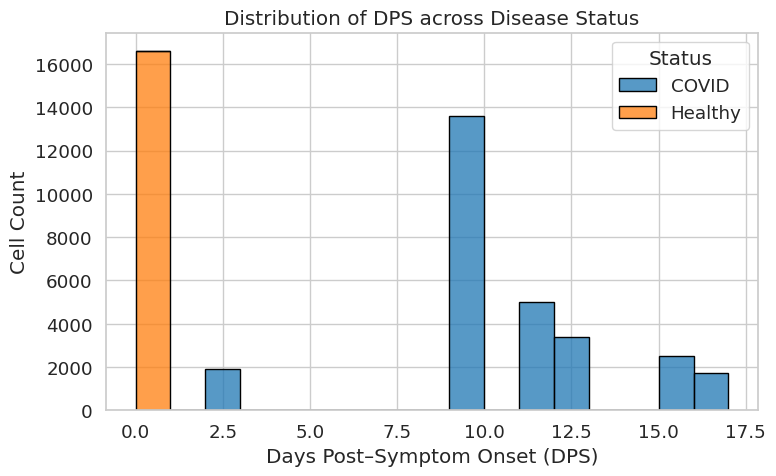

           count       mean       std  min  25%  50%   75%   max
Status                                                          
COVID    28094.0  10.211647  3.140532  2.0  9.0  9.0  12.0  16.0
Healthy  16627.0   0.000000  0.000000  0.0  0.0  0.0   0.0   0.0
Mann-Whitney U test statistic: 467118938.0, p-value: 0.0


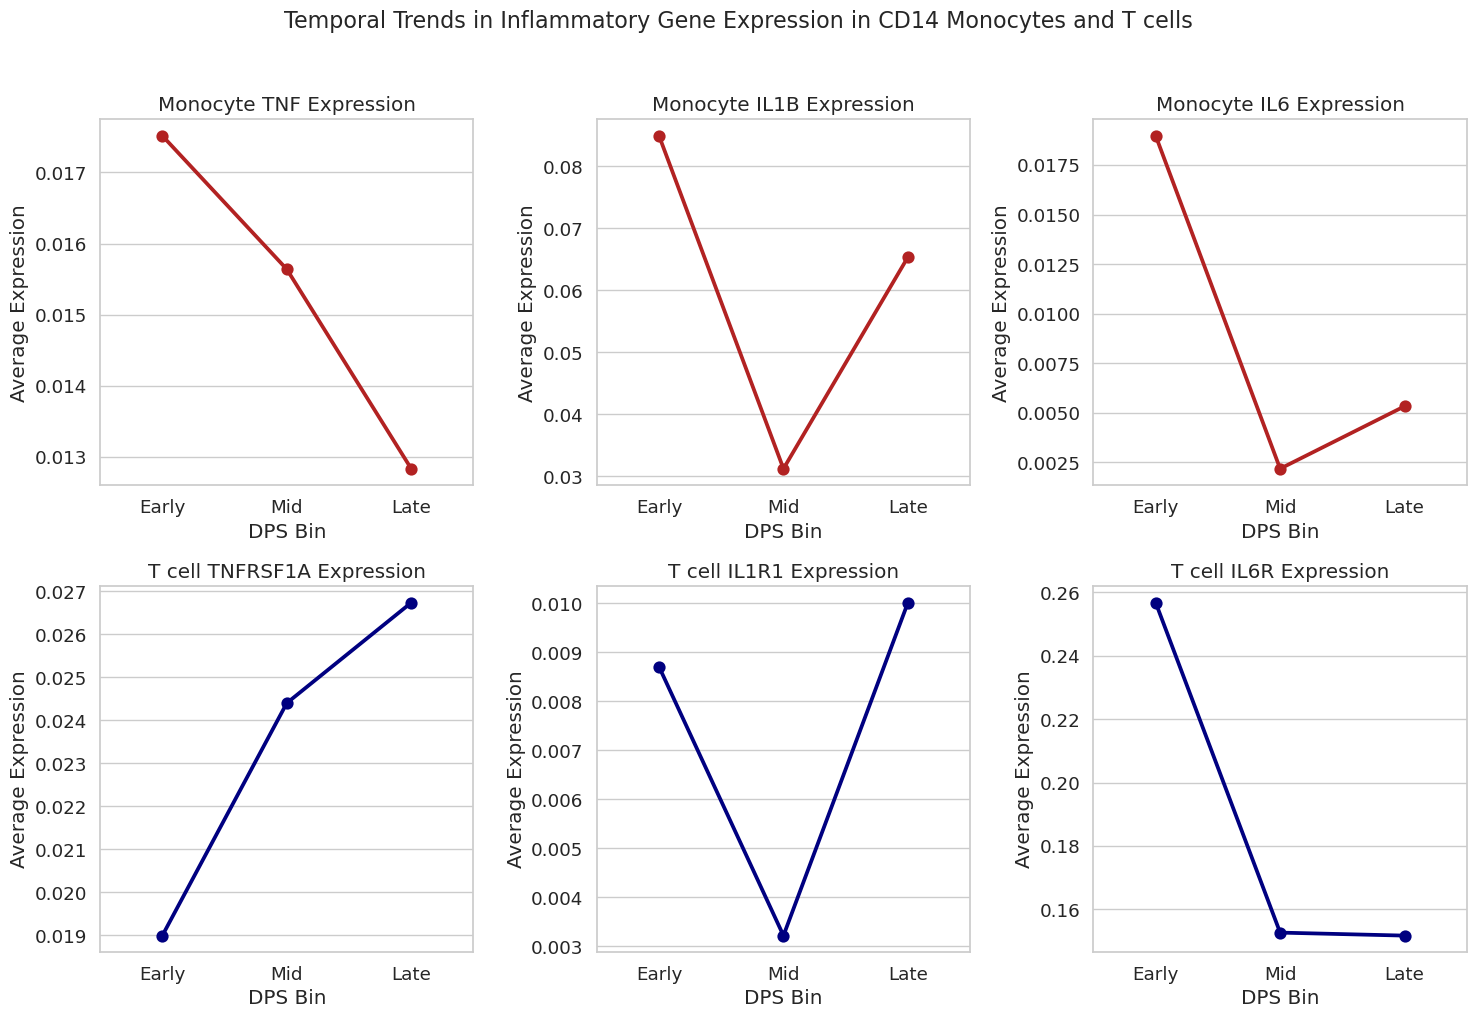

Spearman correlation for monocyte ligands:
TNF: Spearman rho = -0.009, p-value = 4.342e-01
IL1B: Spearman rho = 0.082, p-value = 9.296e-14
IL6: Spearman rho = 0.022, p-value = 5.016e-02

Spearman correlation for T cell receptors:
TNFRSF1A: Spearman rho = -0.003, p-value = 7.619e-01
IL1R1: Spearman rho = 0.044, p-value = 2.338e-05
IL6R: Spearman rho = -0.023, p-value = 2.274e-02


normalizing counts per cell


    finished (0:00:00)


computing neighbors


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:45)


computing Diffusion Maps using n_comps=15(=n_dcs)


computing transitions


    finished (0:00:00)


    eigenvalues of transition matrix
    [ 1.          0.9484763   0.9152665   0.8811249   0.8704351   0.8610376
      0.8291368   0.8197036   0.8050544  -0.7974767  -0.8184017  -0.82015586
     -0.85935295 -0.8708433  -0.91856396]


    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


computing Diffusion Pseudotime using n_dcs=10


    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


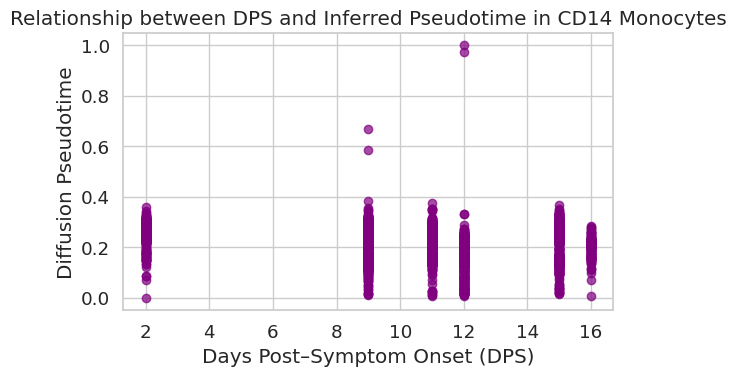

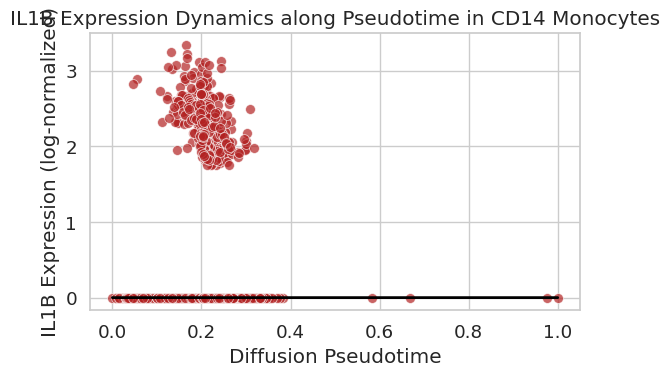

Spearman correlation between diffusion pseudotime and IL1B expression: rho = -0.018, p-value = 9.318e-02


In [4]:
#!/usr/bin/env python
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, spearmanr

# First Step: Exploratory analysis of DPS distribution across disease statuses

# Ensure that 'DPS' and 'Status' columns exist in adata.obs
assert 'DPS' in adata.obs.columns, "DPS column is missing from adata.obs"
assert 'Status' in adata.obs.columns, "Status column is missing from adata.obs"

# Convert DPS to numeric, coercing when necessary
adata.obs['DPS'] = pd.to_numeric(adata.obs['DPS'], errors='coerce')

# Drop any rows where DPS conversion resulted in NaN
obs_df = adata.obs.dropna(subset=['DPS']).copy()

# Print unique values for DPS and Status
print('Unique values for DPS:', obs_df['DPS'].unique())
print('Unique values for Status:', obs_df['Status'].unique())

# Plot the distribution of DPS for each status (COVID vs Healthy) using seaborn's histplot with stacking
plt.figure(figsize=(8, 5))
max_dps = int(obs_df['DPS'].max())
bins = list(range(0, max_dps + 2))
sns.histplot(data=obs_df, x='DPS', hue='Status', multiple='stack', bins=bins, edgecolor='black')
plt.xlabel('Days Post–Symptom Onset (DPS)')
plt.ylabel('Cell Count')
plt.title('Distribution of DPS across Disease Status')
plt.tight_layout()
plt.show()

# Print summary statistics for DPS by Status
print(obs_df.groupby('Status')['DPS'].describe())

# Preliminary statistical test: Mann-Whitney U test to compare DPS distributions between COVID and Healthy samples
covid_dps = obs_df[obs_df['Status'] == 'COVID']['DPS']
healthy_dps = obs_df[obs_df['Status'] == 'Healthy']['DPS']

if len(covid_dps) > 0 and len(healthy_dps) > 0:
    stat, p_value = mannwhitneyu(covid_dps, healthy_dps, alternative='two-sided')
    print(f"Mann-Whitney U test statistic: {stat}, p-value: {p_value}")
else:
    print("Not enough data in one of the groups to perform Mann-Whitney U test.")

# Step 2: Analyze temporal changes in monocyte-T cell communication via inflammatory ligand-receptor pairs

covid_adata = adata[adata.obs['Status'] == 'COVID', :].copy()

monocytes = covid_adata[covid_adata.obs['cell_type_coarse'] == 'CD14 Monocyte', :].copy()
t_cells = covid_adata[covid_adata.obs['cell_type_coarse'].isin(['CD4 T', 'CD8 T']), :].copy()

min_dps = covid_adata.obs['DPS'].min()
max_dps = covid_adata.obs['DPS'].max()
bins_edges = [min_dps, 5, 10, max_dps + 1]
labels = ['Early', 'Mid', 'Late']

monocytes.obs['DPS_bin'] = pd.cut(monocytes.obs['DPS'], bins=bins_edges, labels=labels, include_lowest=True)
t_cells.obs['DPS_bin'] = pd.cut(t_cells.obs['DPS'], bins=bins_edges, labels=labels, include_lowest=True)

bin_midpoints = {
    'Early': (min_dps + 5) / 2,
    'Mid': (5 + 10) / 2,
    'Late': (10 + (max_dps + 1)) / 2
}

ligand_genes = ['TNF', 'IL1B', 'IL6']
receptor_genes = ['TNFRSF1A', 'IL1R1', 'IL6R']

all_genes = list(adata.var_names)
for gene in ligand_genes + receptor_genes:
    if gene not in all_genes:
        print(f"Warning: {gene} not found in the dataset.")

mono_df = monocytes.to_df()[ligand_genes]
mono_df['DPS_bin'] = monocytes.obs['DPS_bin'].values
mono_summary = mono_df.groupby('DPS_bin').mean().reset_index()
mono_summary['DPS_mid'] = mono_summary['DPS_bin'].map(bin_midpoints)

t_df = t_cells.to_df()[receptor_genes]
t_df['DPS_bin'] = t_cells.obs['DPS_bin'].values
nt_summary = t_df.groupby('DPS_bin').mean().reset_index()
nt_summary['DPS_mid'] = nt_summary['DPS_bin'].map(bin_midpoints)

fig, axes = plt.subplots(2, len(ligand_genes), figsize=(5 * len(ligand_genes), 10), sharex=False)

for idx, gene in enumerate(ligand_genes):
    ax = axes[0, idx]
    sns.pointplot(x='DPS_bin', y=gene, data=mono_summary, ax=ax, color='firebrick', errwidth=0, ci=None)
    ax.plot(mono_summary['DPS_bin'], mono_summary[gene], marker='o', color='firebrick', linestyle='--')
    sns.regplot(x='DPS_mid', y=gene, data=mono_summary, ax=ax, scatter=False, lowess=True, color='black', line_kws={'linestyle':'-', 'linewidth':2})
    ax.set_title(f"Monocyte {gene} Expression")
    ax.set_xlabel('DPS Bin')
    ax.set_xticklabels(mono_summary['DPS_bin'].astype(str))
    ax.set_ylabel('Average Expression')
    ax.set_xlim(-0.5, len(labels)-0.5)

for idx, gene in enumerate(receptor_genes):
    ax = axes[1, idx]
    sns.pointplot(x='DPS_bin', y=gene, data=nt_summary, ax=ax, color='navy', errwidth=0, ci=None)
    ax.plot(nt_summary['DPS_bin'], nt_summary[gene], marker='o', color='navy', linestyle='--')
    sns.regplot(x='DPS_mid', y=gene, data=nt_summary, ax=ax, scatter=False, lowess=True, color='black', line_kws={'linestyle':'-', 'linewidth':2})
    ax.set_title(f"T cell {gene} Expression")
    ax.set_xlabel('DPS Bin')
    ax.set_xticklabels(nt_summary['DPS_bin'].astype(str))
    ax.set_ylabel('Average Expression')
    ax.set_xlim(-0.5, len(labels)-0.5)

plt.suptitle('Temporal Trends in Inflammatory Gene Expression in CD14 Monocytes and T cells', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

mono_expr = monocytes.to_df()[ligand_genes]
mono_expr['DPS'] = monocytes.obs['DPS'].values
print("Spearman correlation for monocyte ligands:")
for gene in ligand_genes:
    coef, p_val = spearmanr(mono_expr['DPS'], mono_expr[gene])
    print(f"{gene}: Spearman rho = {coef:.3f}, p-value = {p_val:.3e}")

t_expr = t_cells.to_df()[receptor_genes]
t_expr['DPS'] = t_cells.obs['DPS'].values
print("\nSpearman correlation for T cell receptors:")
for gene in receptor_genes:
    coef, p_val = spearmanr(t_expr['DPS'], t_expr[gene])
    print(f"{gene}: Spearman rho = {coef:.3f}, p-value = {p_val:.3e}")

# Additional Code Block with Diffusion Pseudotime Analysis

# Ensure required metadata fields are present
required_columns = ['Status', 'cell_type_coarse', 'DPS']
for col in required_columns:
    assert col in adata.obs.columns, f"{col} column is missing from adata.obs"

# Convert DPS to numeric explicitly
adata.obs['DPS'] = pd.to_numeric(adata.obs['DPS'], errors='coerce')
if adata.obs['DPS'].isna().any():
    raise ValueError('Some cells have non-numeric DPS values. Please clean the data before analysis.')

# Subset the adata object to include only COVID-19 samples and CD14 monocytes
covid_monocytes = adata[(adata.obs['Status'] == 'COVID') & (adata.obs['cell_type_coarse'] == 'CD14 Monocyte')].copy()
if covid_monocytes.n_obs == 0:
    raise ValueError('No cells found for COVID-19 CD14 Monocytes.')

# Preprocess: Normalize and log-transform the data
sc.pp.normalize_total(covid_monocytes, target_sum=1e4)
sc.pp.log1p(covid_monocytes)

# Compute the neighborhood graph
sc.pp.neighbors(covid_monocytes, n_neighbors=15, use_rep='X')

# Check that DPS metadata exists and select the cell(s) with the minimum DPS value
if 'DPS' not in covid_monocytes.obs.columns:
    raise ValueError('DPS column is missing in the subset observations.')

min_dps = covid_monocytes.obs['DPS'].min()
root_candidates = covid_monocytes.obs.index[covid_monocytes.obs['DPS'] == min_dps].tolist()
if len(root_candidates) == 0:
    raise ValueError('No cell found with minimum DPS value.')
root_idx = root_candidates[0]

# Set the root index for diffusion pseudotime
covid_monocytes.uns['iroot'] = list(covid_monocytes.obs_names).index(root_idx)
sc.tl.dpt(covid_monocytes)

# Retrieve the inferred pseudotime values
pseudotime = covid_monocytes.obs['dpt_pseudotime']

# Validate the pseudotime by plotting against DPS
plt.figure(figsize=(6, 4))
plt.scatter(covid_monocytes.obs['DPS'], pseudotime, alpha=0.7, color='purple')
plt.xlabel('Days Post–Symptom Onset (DPS)')
plt.ylabel('Diffusion Pseudotime')
plt.title('Relationship between DPS and Inferred Pseudotime in CD14 Monocytes')
plt.tight_layout()
plt.show()

# Visualize IL1B expression along pseudotime (verify that the gene exists first)
if 'IL1B' in covid_monocytes.var_names:
    il1b_data = covid_monocytes[:, 'IL1B'].X
    il1b_expr = il1b_data.toarray().flatten() if hasattr(il1b_data, 'toarray') else il1b_data.flatten()
    
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=pseudotime, y=il1b_expr, color='firebrick', s=50, alpha=0.7)
    sns.regplot(x=pseudotime, y=il1b_expr, scatter=False, lowess=True, color='black', line_kws={'linestyle': '-', 'linewidth':2})
    plt.xlabel('Diffusion Pseudotime')
    plt.ylabel('IL1B Expression (log-normalized)')
    plt.title('IL1B Expression Dynamics along Pseudotime in CD14 Monocytes')
    plt.tight_layout()
    plt.show()
else:
    print('Warning: IL1B not found in the dataset. Skipping IL1B visualization and correlation.')

# Statistical validation: Compute Spearman correlation between pseudotime and IL1B expression
if 'IL1B' in covid_monocytes.var_names:
    coef, p_val = spearmanr(pseudotime, il1b_expr)
    print(f"Spearman correlation between diffusion pseudotime and IL1B expression: rho = {coef:.3f}, p-value = {p_val:.3e}")
else:
    print('Skipping Spearman correlation for IL1B due to missing gene.')

## Subset the COVID‐19 samples and select CD14 monocytes and T cells (CD4 and CD8 T cells) as in previous analyses.

Composite Interaction Scores by DPS Bin:
  DPS_bin  Interaction_Score  DPS_mid
0   Early           0.003837      3.5
1     Mid           0.000982      7.5
2    Late           0.001748     13.5
Spearman correlation between DPS midpoints and interaction scores: rho = -0.500, p-value = 6.667e-01


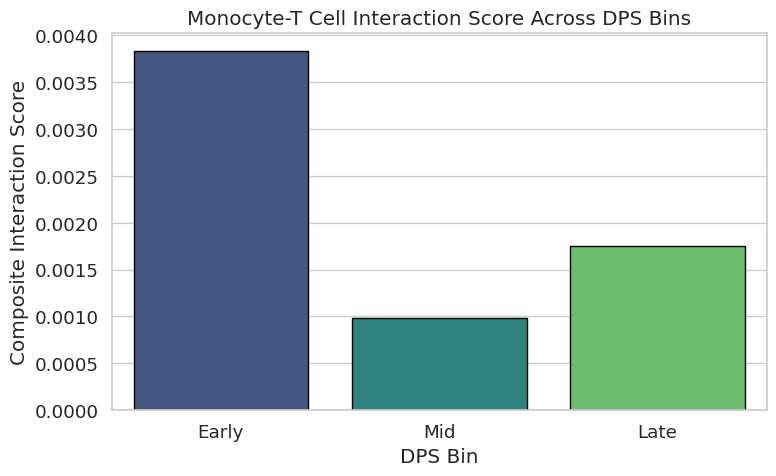

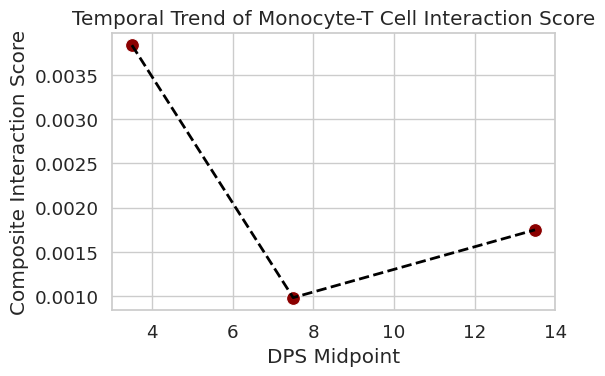

In [5]:
#!/usr/bin/env python
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# Subset COVID‐19 samples
covid_adata = adata[adata.obs['Status'] == 'COVID', :].copy()

# Subset CD14 Monocytes and T cells (CD4 and CD8 T cells)
monocytes = covid_adata[covid_adata.obs['cell_type_coarse'] == 'CD14 Monocyte', :].copy()
t_cells = covid_adata[covid_adata.obs['cell_type_coarse'].isin(['CD4 T', 'CD8 T']), :].copy()

# Define DPS bins (using established cutoffs) and assign cells accordingly
min_dps = covid_adata.obs['DPS'].min()
max_dps = covid_adata.obs['DPS'].max()
bins_edges = [min_dps, 5, 10, max_dps + 1]
labels = ['Early', 'Mid', 'Late']

monocytes.obs['DPS_bin'] = pd.cut(monocytes.obs['DPS'], bins=bins_edges, labels=labels, include_lowest=True)
t_cells.obs['DPS_bin'] = pd.cut(t_cells.obs['DPS'], bins=bins_edges, labels=labels, include_lowest=True)

# Define DPS bin midpoints for later plotting/statistics
bin_midpoints = {
    'Early': (min_dps + 5) / 2,
    'Mid': (5 + 10) / 2,
    'Late': (10 + (max_dps + 1)) / 2
}

# Define ligand and receptor genes
ligand_genes = ['TNF', 'IL1B', 'IL6']
receptor_genes = ['TNFRSF1A', 'IL1R1', 'IL6R']

# Verify that all required genes are present in the dataset; halt if any key gene is missing
all_genes = list(adata.var_names)
missing_genes = [gene for gene in (ligand_genes + receptor_genes) if gene not in all_genes]
if missing_genes:
    raise ValueError(f"Missing key inflammatory gene(s): {', '.join(missing_genes)}")

# Compute average expression per DPS bin for monocytes (ligands)
mono_df = monocytes.to_df()[ligand_genes].copy()
mono_df['DPS_bin'] = monocytes.obs['DPS_bin'].values
ligand_summary = mono_df.groupby('DPS_bin').mean()

# Compute average expression per DPS bin for T cells (receptors)
tcell_df = t_cells.to_df()[receptor_genes].copy()
tcell_df['DPS_bin'] = t_cells.obs['DPS_bin'].values
receptor_summary = tcell_df.groupby('DPS_bin').mean()

# Calculate interaction scores for each ligand-receptor pair for each DPS bin
# The product is used because it accentuates cases with simultaneous high expression
interaction_scores = {}
for bin_label in labels:
    if bin_label in ligand_summary.index and bin_label in receptor_summary.index:
        pair_scores = []
        for lg in ligand_genes:
            for rg in receptor_genes:
                score = ligand_summary.loc[bin_label, lg] * receptor_summary.loc[bin_label, rg]
                pair_scores.append(score)
        interaction_scores[bin_label] = np.mean(pair_scores)
    else:
        interaction_scores[bin_label] = np.nan

# Convert interaction scores to a DataFrame for plotting
interaction_df = pd.DataFrame({
    'DPS_bin': list(interaction_scores.keys()),
    'Interaction_Score': list(interaction_scores.values())
})
interaction_df['DPS_mid'] = interaction_df['DPS_bin'].map(bin_midpoints)

print('Composite Interaction Scores by DPS Bin:')
print(interaction_df)

# Perform Spearman correlation between DPS midpoints and interaction scores
rho, p_val = spearmanr(interaction_df['DPS_mid'], interaction_df['Interaction_Score'], nan_policy='omit')
print(f"Spearman correlation between DPS midpoints and interaction scores: rho = {rho:.3f}, p-value = {p_val:.3e}")

# Visualization: Bar plot of composite interaction scores
plt.figure(figsize=(8, 5))
sns.barplot(x='DPS_bin', y='Interaction_Score', data=interaction_df, palette='viridis', edgecolor='black')
plt.xlabel('DPS Bin')
plt.ylabel('Composite Interaction Score')
plt.title('Monocyte-T Cell Interaction Score Across DPS Bins')
plt.tight_layout()
plt.show()

# Visualization: Scatter plot with lowess regression overlay
plt.figure(figsize=(6, 4))
sns.scatterplot(x='DPS_mid', y='Interaction_Score', data=interaction_df, s=100, color='darkred')
sns.regplot(x='DPS_mid', y='Interaction_Score', data=interaction_df, scatter=False, lowess=True, color='black', line_kws={'linestyle':'--','linewidth':2})
plt.xlabel('DPS Midpoint')
plt.ylabel('Composite Interaction Score')
plt.title('Temporal Trend of Monocyte-T Cell Interaction Score')
plt.tight_layout()
plt.show()

## Subset the COVID-19 samples from the AnnData object and re-establish the CD14 monocytes and T cell (CD4 and CD8) subsets.

computing score 'inflammatory_ligand_module_score'


    finished: added
    'inflammatory_ligand_module_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)


computing score 'inflammatory_receptor_module_score'


    finished: added
    'inflammatory_receptor_module_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)


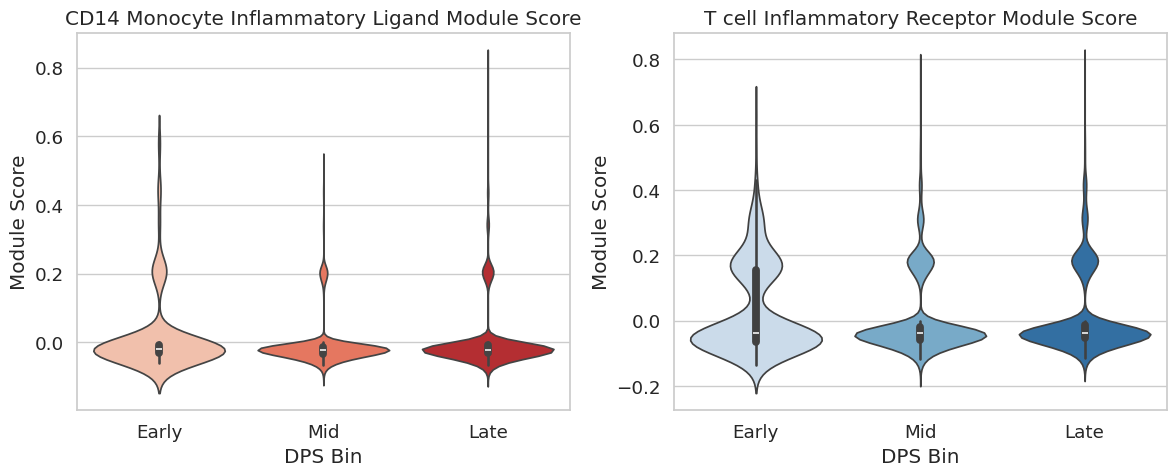

Monocyte ligand module score Early vs Late Mann-Whitney U test: stat = 679274.0, p-value = 9.886e-02
T cell receptor module score Early vs Late Mann-Whitney U test: stat = 628300.5, p-value = 4.361e-01
Spearman correlation in monocytes: rho = 0.103, p-value = 4.388e-21
Spearman correlation in T cells: rho = 0.039, p-value = 1.643e-04


In [6]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu, spearmanr

# Subset COVID-19 samples and extract CD14 monocytes and T cells (CD4 and CD8 T cells)
covid_adata = adata[adata.obs['Status'] == 'COVID', :].copy()
monocytes = covid_adata[covid_adata.obs['cell_type_coarse'] == 'CD14 Monocyte', :].copy()
t_cells = covid_adata[covid_adata.obs['cell_type_coarse'].isin(['CD4 T', 'CD8 T']), :].copy()

# Define gene sets for module scoring
ligand_genes = ['TNF', 'IL1B', 'IL6']
receptor_genes = ['TNFRSF1A', 'IL1R1', 'IL6R']

# Verify that all required genes are present in the dataset; raise an error if any key gene is missing
missing_genes = [gene for gene in (ligand_genes + receptor_genes) if gene not in adata.var_names]
if missing_genes:
    raise ValueError(f"Missing key inflammatory gene(s): {', '.join(missing_genes)}")


def compute_module_score(adata_subset, gene_list, score_name):
    """Compute and assign a module score based on a given list of genes.

    Parameters:
      adata_subset (AnnData): The AnnData object subset on which to compute the score.
      gene_list (list): List of gene names used to compute the module score.
      score_name (str): The name for the new score column in adata_subset.obs.

    Returns:
      AnnData: The input AnnData object with a new column in .obs for the module score.
    """
    sc.tl.score_genes(adata_subset, gene_list=gene_list, score_name=score_name, copy=False)
    return adata_subset

# Compute cell-level module scores using Scanpy's score_genes and use consistent naming with the hypothesis
monocytes = compute_module_score(monocytes, ligand_genes, 'inflammatory_ligand_module_score')
t_cells = compute_module_score(t_cells, receptor_genes, 'inflammatory_receptor_module_score')

# Define DPS bins based on the range observed in covid_adata
min_dps = float(covid_adata.obs['DPS'].min())
max_dps = float(covid_adata.obs['DPS'].max())
bins_edges = [min_dps, 5, 10, max_dps + 1]
labels = ['Early', 'Mid', 'Late']

monocytes.obs['DPS_bin'] = pd.cut(monocytes.obs['DPS'], bins=bins_edges, labels=labels, include_lowest=True)
t_cells.obs['DPS_bin'] = pd.cut(t_cells.obs['DPS'], bins=bins_edges, labels=labels, include_lowest=True)

# Visualization: Violin plots of inflammatory module scores stratified by DPS bins
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.violinplot(x='DPS_bin', y='inflammatory_ligand_module_score', data=monocytes.obs, ax=axes[0], palette='Reds')
axes[0].set_title('CD14 Monocyte Inflammatory Ligand Module Score')
axes[0].set_xlabel('DPS Bin')
axes[0].set_ylabel('Module Score')

sns.violinplot(x='DPS_bin', y='inflammatory_receptor_module_score', data=t_cells.obs, ax=axes[1], palette='Blues')
axes[1].set_title('T cell Inflammatory Receptor Module Score')
axes[1].set_xlabel('DPS Bin')
axes[1].set_ylabel('Module Score')

plt.tight_layout()
plt.show()

# Statistical Testing: Mann-Whitney U tests comparing Early vs Late DPS bins for each module score
ligand_early = monocytes.obs.loc[monocytes.obs['DPS_bin'] == 'Early', 'inflammatory_ligand_module_score']
ligand_late = monocytes.obs.loc[monocytes.obs['DPS_bin'] == 'Late', 'inflammatory_ligand_module_score']

tcell_early = t_cells.obs.loc[t_cells.obs['DPS_bin'] == 'Early', 'inflammatory_receptor_module_score']
tcell_late = t_cells.obs.loc[t_cells.obs['DPS_bin'] == 'Late', 'inflammatory_receptor_module_score']

stat_mon, p_mon = mannwhitneyu(ligand_early, ligand_late, alternative='two-sided')
print(f"Monocyte ligand module score Early vs Late Mann-Whitney U test: stat = {stat_mon}, p-value = {p_mon:.3e}")

stat_tcell, p_tcell = mannwhitneyu(tcell_early, tcell_late, alternative='two-sided')
print(f"T cell receptor module score Early vs Late Mann-Whitney U test: stat = {stat_tcell}, p-value = {p_tcell:.3e}")

# Correlation Analysis: Spearman correlation between individual cell module scores and DPS
rho_mon, p_mon_rho = spearmanr(monocytes.obs['DPS'], monocytes.obs['inflammatory_ligand_module_score'])
rho_tcell, p_tcell_rho = spearmanr(t_cells.obs['DPS'], t_cells.obs['inflammatory_receptor_module_score'])

print(f"Spearman correlation in monocytes: rho = {rho_mon:.3f}, p-value = {p_mon_rho:.3e}")
print(f"Spearman correlation in T cells: rho = {rho_tcell:.3f}, p-value = {p_tcell_rho:.3e}")

## Subset COVID‐19 samples from the anndata object and further subset CD14 monocytes and T cells (CD4 and CD8) ensuring donor information is available.

In [ ]:
#!/usr/bin/env python
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import warnings

# Function to subset data by cell type and ensure donor annotation is present

def subset_cells(adata, cell_type_col, cell_types, donor_col='Donor_full'):
    subset = adata[adata.obs[cell_type_col].isin(cell_types), :].copy()
    if donor_col not in subset.obs.columns:
        raise ValueError(f"{donor_col} column is missing in the provided data subset.")
    return subset

# Function to compute donor-level median expression for a given gene list with cell count warning

def compute_donor_medians(adata_subset, gene_list, donor_col='Donor_full', count_threshold=10):
    # Convert expression matrix to DataFrame
    expr_df = adata_subset.to_df()[gene_list].copy()
    expr_df[donor_col] = adata_subset.obs[donor_col].values
    # Check cell count per donor and warn if below threshold
    cell_counts = adata_subset.obs.groupby(donor_col).size()
    low_count_donors = cell_counts[cell_counts < count_threshold].index.tolist()
    if low_count_donors:
        warnings.warn(f"The following donors have fewer than {count_threshold} cells: {', '.join(low_count_donors)}")
    # Compute median per donor
    donor_medians = expr_df.groupby(donor_col).median().reset_index()
    return donor_medians

# Main execution block

# Subset COVID-19 samples
covid_adata = adata[adata.obs['Status'] == 'COVID', :].copy()

# Subset CD14 Monocytes and T cells (CD4 and CD8 T cells) using the modular function
monocytes = subset_cells(covid_adata, 'cell_type_coarse', ['CD14 Monocyte'])
t_cells = subset_cells(covid_adata, 'cell_type_coarse', ['CD4 T', 'CD8 T'])

# Define inflammatory ligand and receptor gene names
ligand_genes = ['TNF', 'IL1B', 'IL6']
receptor_genes = ['TNFRSF1A', 'IL1R1', 'IL6R']

# Verify that the required genes are present in the dataset
all_genes = list(adata.var_names)
for gene in ligand_genes + receptor_genes:
    if gene not in all_genes:
        raise ValueError(f"Required gene {gene} is missing from the dataset.")

# Compute donor-level median expression for monocyte ligands with a minimum cell count threshold
monocyte_medians = compute_donor_medians(monocytes, ligand_genes, donor_col='Donor_full', count_threshold=10)

# Compute donor-level median expression for T cell receptors
tcell_medians = compute_donor_medians(t_cells, receptor_genes, donor_col='Donor_full', count_threshold=10)

# Merge the donor-level summaries, keeping only donors present in both cell types
merged_df = pd.merge(monocyte_medians, tcell_medians, on='Donor_full', suffixes=('_ligand', '_receptor'))
print('Donor-level median expression summary:')
print(merged_df)

# For each ligand-receptor pair, compute Spearman correlation and generate scatter plots with lowess regression
pairs = list(zip(ligand_genes, receptor_genes))

# Setup figure with one subplot per pair
n_pairs = len(pairs)
fig, axes = plt.subplots(1, n_pairs, figsize=(5 * n_pairs, 5))
if n_pairs == 1:
    axes = [axes]  # ensure axes is iterable

correlation_results = {}

for idx, (ligand, receptor) in enumerate(pairs):
    x = merged_df[f'{ligand}_ligand']
    y = merged_df[f'{receptor}_receptor']
    # Compute Spearman correlation
    rho, p_val = spearmanr(x, y)
    correlation_results[f'{ligand}-{receptor}'] = (rho, p_val)
    
    ax = axes[idx]
    sns.scatterplot(x=x, y=y, s=100, color='teal', ax=ax)
    sns.regplot(x=x, y=y, scatter=False, lowess=True, color='black', line_kws={'linestyle': '--', 'linewidth': 2}, ax=ax)
    ax.set_xlabel(f'Median {ligand} (Monocytes)')
    ax.set_ylabel(f'Median {receptor} (T cells)')
    ax.set_title(f'{ligand} vs. {receptor}\nSpearman r = {rho:.2f}, p = {p_val:.2e}')

plt.suptitle('Donor-Level Correlation of Inflammatory Ligand-Receptor Pairs', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# Print correlation results
print('Spearman correlation results for ligand-receptor pairs:')
for pair, (rho, p_val) in correlation_results.items():
    print(f'{pair}: Spearman r = {rho:.3f}, p-value = {p_val:.3e}')